In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle as pk
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
import numpy as np, scipy.stats as st
from sklearn.decomposition import PCA
import copy
import warnings
warnings.filterwarnings('ignore')

## Do this same analysis (Method 2) on the UMass Private Well Dataset

In [2]:
receptor_df = pd.read_csv('../../../data/modeling_data/private_well_holdout.csv')

In [3]:
orig_df = receptor_df.copy()

In [4]:
# Wastewater also contains extra compounds that are not a part of the PFAS18 collection (PFDS, PFPeA, PFTeDA, PFPeS, PFNS, PFHpS)
# Remove these variables based on PFAS_18 compounds list

pfas6 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS6']]
pfas6 = pfas6[~(pfas6['PFAS6'].isna())]['Acronym']

In [5]:
pfas_vars = utils.get_pfas_vars(df = receptor_df,
                                pfas18 = pfas6)

Normalize from 0 to 1 for display purposes (e.g., EDA) only. The actual data will be z-score normalized
(standardized) before PCA and HC.

In [6]:
# receptor_df = receptor_df_final.copy()
receptor_df_eda = utils.normalize_over_partitions(df = receptor_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Matrix',
                                              scaler_fn = 'MinMax')

## Visualize Profile

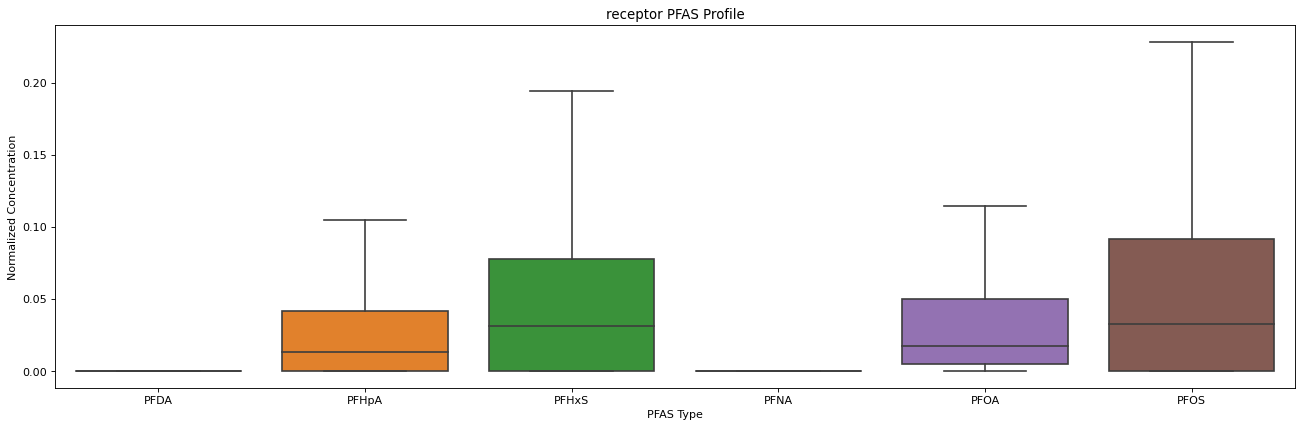

In [7]:
# Should this be in molecular weight order?? - Easier to compare across different sources/samples

plt.figure(figsize=(20, 6), dpi=80)
plt.title('receptor PFAS Profile')

# pd.melt(receptor_df_eda[pfas_vars])
sns.boxplot(x="variable", y="value", data=pd.melt(receptor_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

In [8]:
input_df = receptor_df_eda[pfas_vars].copy()

### Transform using Profiles

In [9]:
num_pcs_dict = {'AFFF' : 2,
           'airport' : 2,
           'other' : 3,
           'residential' : 3}

other_PC_profiles_names = {'PC1' : 'Industrial Manufacturing Mix', 
                           'PC2' : 'Waste/Landfills', 
                           'PC3':'Other (Coatings/Inks and other)'}

Standardize receptor data

In [10]:
receptor_df_pca = copy.deepcopy(receptor_df)
receptor_df_pca = utils.normalize_over_partitions(df = receptor_df_pca, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Matrix',
                                          scaler_fn = 'Zscore')
input_df = receptor_df_pca[pfas_vars].copy()

AFFF

In [11]:
# Create AFFF transformation based on number of principal components
afff_df = pd.read_csv('../../../data/modeling_data/source_attribution/afff_source.csv')

afff_APCS_df = utils.APCS_pipeline(source_df = afff_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'AFFF',
                                   units_col = 'Matrix',
                                   num_pcs = num_pcs_dict)

Airport

In [12]:
# Create airport transformation based on number of principal components
airport_df = pd.read_csv('../../../data/modeling_data/source_attribution/airport_source.csv')

airport_APCS_df = utils.APCS_pipeline(source_df = airport_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'airport',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Other

In [13]:
# Create other transformation based on number of principal components
other_df = pd.read_csv('../../../data/modeling_data/source_attribution/other_source.csv')

other_APCS_df = utils.APCS_pipeline(source_df = other_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'other',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Residential

In [14]:
# Create residential transformation based on number of principal components
residential_df = pd.read_csv('../../../data/modeling_data/source_attribution/residential_source.csv')

residential_APCS_df = utils.APCS_pipeline(source_df = residential_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'residential',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Create modeling dataset

In [15]:
sources = num_pcs_dict.keys()
concat_df = pd.concat([afff_APCS_df, airport_APCS_df, residential_APCS_df, other_APCS_df], axis = 1)
predictor_list = concat_df.columns
concat_df[pfas_vars] = receptor_df[pfas_vars]

### Attribution Modeling

Check for highly correlated variables

In [16]:
print('Top Absolute Correlations')
utils.get_top_abs_correlations(concat_df[predictor_list],
                        corr_cutoff = 0.85)

Top Absolute Correlations


,level_0,level_1,0
0,airport_1,other_1,0.992504
1,airport_0,residential_0,0.959544
2,AFFF_1,other_0,0.851380


Since airport_0 is most highly correlated with airport_0 -- if removed from model, then airport_0 will share contribution with residential_0. Since, airport_0 is not too highly correlated with AFFF_0 - no additional change beyond this is needed

In [17]:
# Manual entry
removed_vars = {'airport_1' : ['other_1'],
                'residential_0' : ['airport_0']}

In [18]:
for var, remove_list in removed_vars.items():
    concat_df.drop(columns = remove_list, inplace = True)
    
predictor_list = concat_df.columns

Fit model

In [19]:
# bootstrap 10 times to get confidence interval
n_iterations = 50
model2_info = utils.fit_model(concat_df, predictor_list, pfas_vars, n_iterations)

Calculate confidence intervals

In [20]:
source_names, means, yerror = utils.calc_contribution_confidence_intervals(concat_df, model2_info, pfas_vars, sources, n_iterations, removed_vars, num_pcs_dict, other_PC_profiles_names)

['AFFF', 'airport', 'Industrial Manufacturing Mix', 'Waste/Landfills', 'Other (Coatings/Inks and other)', 'residential']
AFFF attribution 95% CI: [ 26.41 , 28.86 ] %
airport attribution 95% CI: [ 16.73 , 18.12 ] %
Industrial Manufacturing Mix attribution 95% CI: [ 8.09 , 9.85 ] %
Waste/Landfills attribution 95% CI: [ 13.15 , 14.93 ] %
Other (Coatings/Inks and other) attribution 95% CI: [ 5.99 , 7.14 ] %
residential attribution 95% CI: [ 24.04 , 26.7 ] %


In [21]:
(23.63 + 26.03)/2

24.83

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

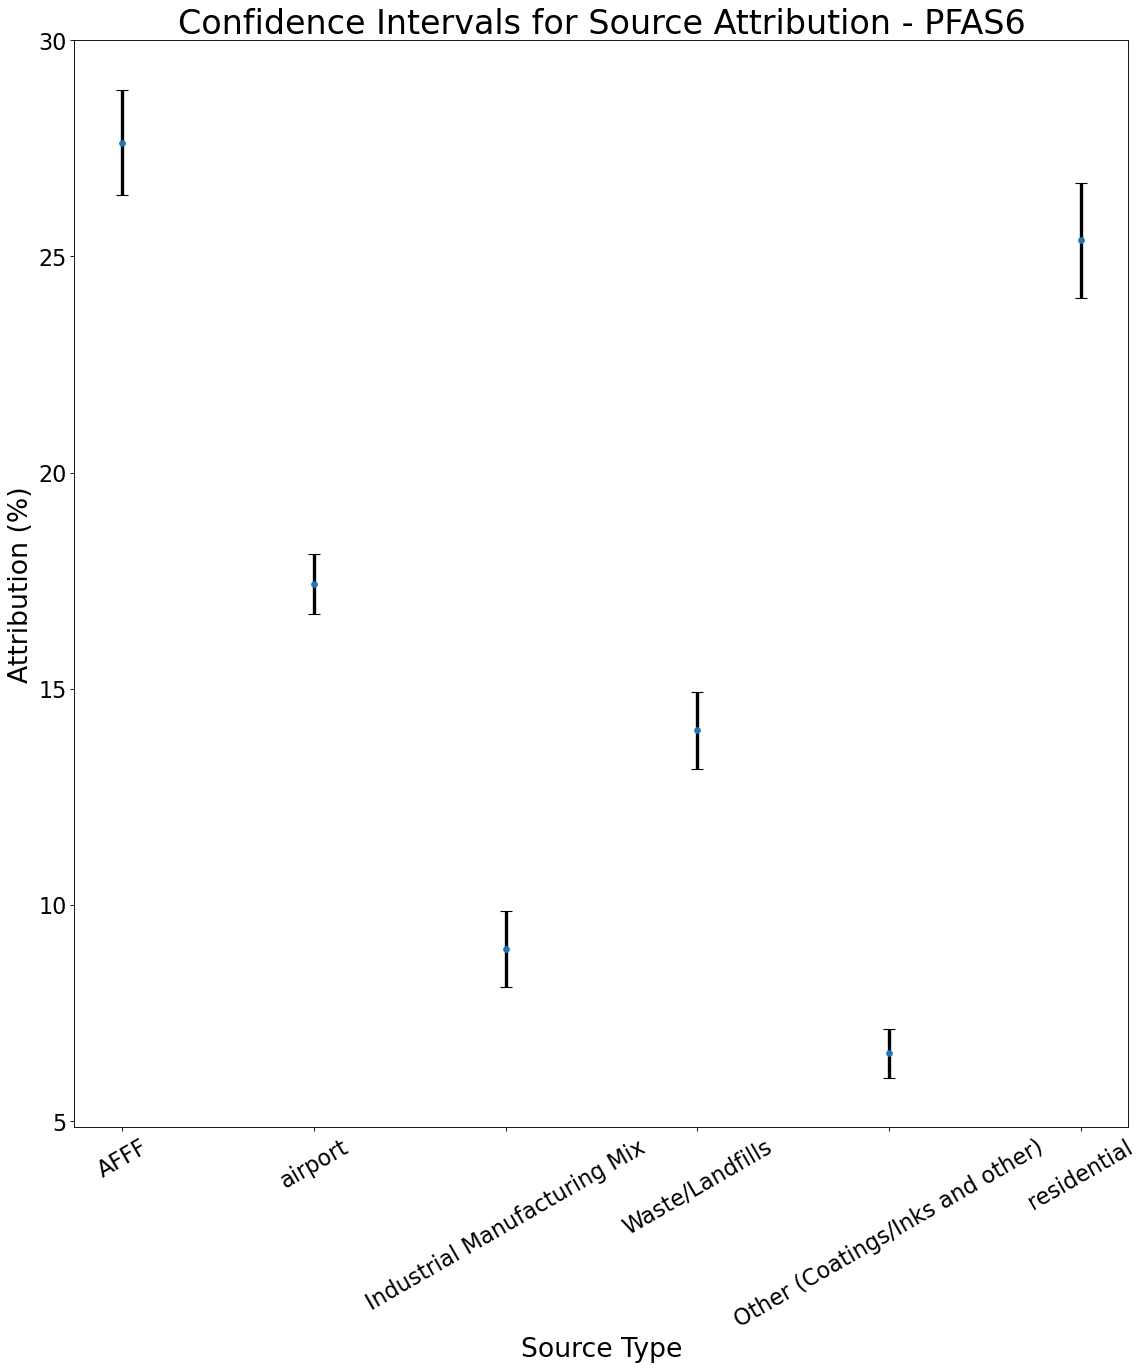

In [22]:
x = source_names
y = means

plt.figure(figsize=(17, 18), dpi=80)
plt.title('Confidence Intervals for Source Attribution - PFAS6', fontsize = 30)

plt.xlabel('Source Type', fontsize = 24)
plt.ylabel('Attribution (%)', fontsize = 24)

plt.errorbar(range(len(x)),y, yerr = yerror, fmt = 'o', ecolor = 'black', capsize = 5, ms = 5, elinewidth = 3)
plt.xticks(range(len(x)), x,fontsize = 20, rotation = 30)
plt.yticks(fontsize = 20)

In [23]:
# (Average variance explained by model, standard deviation)
avg_score = utils.calculate_average_model_score(model2_info, n_iterations, sources, pfas_vars)
avg_score

{'PFDA': (72.77, 19.87),
 'PFHpA': (70.32, 3.31),
 'PFHxS': (75.39, 2.11),
 'PFNA': (78.79, 3.52),
 'PFOA': (68.89, 3.25),
 'PFOS': (68.78, 2.63)}

In [24]:
# get weighted average score of all PFAS
_sum = 0
for pfas in pfas_vars: 
    _sum += sum(concat_df[pfas])

weights = {}
for pfas in pfas_vars:
    weights[pfas] = sum(concat_df[pfas]) / _sum
    
_avg_score = 0
for pfas in pfas_vars:
    _avg_score += avg_score[pfas][0] * weights[pfas]

In [25]:
_avg_score

70.20642982091833

****

In [26]:
for pfas in pfas_vars[:]:

    rs = resample(concat_df, n_samples = concat_df.shape[0], random_state = 42).copy()
    X = rs[predictor_list]
    y = rs[pfas].copy()

    lm = PoissonRegressor().fit(X, y)
    lm.intercept_
    lm.coef_
    print(pfas, lm.score(X, y))
    mean_squared_error(y, lm.predict(X))

PFDA 0.8622136883281124
PFHpA 0.7453306310350479
PFHxS 0.7849690195690566
PFNA 0.8467510100770484
PFOA 0.6821892559559399
PFOS 0.6826785964962032


In [27]:
X.reset_index(drop = True, inplace = True)

In [28]:
y.reset_index(drop = True, inplace = True)

In [29]:
y_pred = lm.predict(X)

In [30]:
y.describe()

count    624.000000
mean       2.530381
std        3.537449
min        0.226500
25%        0.226500
50%        1.200000
75%        3.212500
max       29.800000
Name: PFOS, dtype: float64

In [31]:
plot_df = pd.DataFrame([y, y_pred]).T.rename(columns = {'PFOS' : 'Original',
                                              'Unnamed 0' : 'Predicted'})

In [32]:
plot_df

,Original,Predicted
0,15.3000,8.918361
1,4.1500,2.322581
2,1.3000,1.636470
3,2.3800,1.890363
4,7.7400,3.558517
...,...,...
619,0.2265,1.399864
620,4.2700,2.886091
621,0.2265,1.211315
622,0.8790,1.539729


In [33]:
plot_df.sort_values('Original', inplace=True)

In [34]:
plot_df = plot_df.reset_index(drop = True)

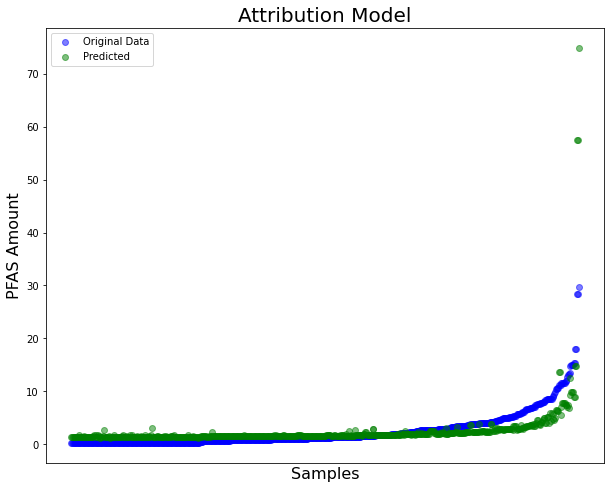

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Attribution Model', fontsize = 20)
ax.set_xlabel("Samples", fontsize = 16)                                
ax.set_ylabel("PFAS Amount", fontsize = 16)
plt.scatter(plot_df.index, plot_df.Original,color='blue',alpha = 0.5, label="Original Data")
plt.scatter(plot_df.index, plot_df.Predicted,color='green',alpha = 0.5,label="Predicted")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()

(array([514.,  64.,  15.,  10.,   7.,   6.,   0.,   1.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.21131536,  2.68592018,  4.16052501,  5.63512984,  7.10973467,
         8.5843395 , 10.05894433, 11.53354916, 13.00815399, 14.48275882,
        15.95736364, 17.43196847, 18.9065733 , 20.38117813, 21.85578296,
        23.33038779, 24.80499262, 26.27959745, 27.75420228, 29.2288071 ,
        30.70341193, 32.17801676, 33.65262159, 35.12722642, 36.60183125,
        38.07643608, 39.55104091, 41.02564574, 42.50025056, 43.97485539,
        45.44946022, 46.92406505, 48.39866988, 49.87327471, 51.34787954,
        52.82248437, 54.2970892 , 55.77169402, 57.24629885, 58.72090368,
        60.19550851, 61.67011334, 63.14471817, 64.619323  , 66.09392783,
 

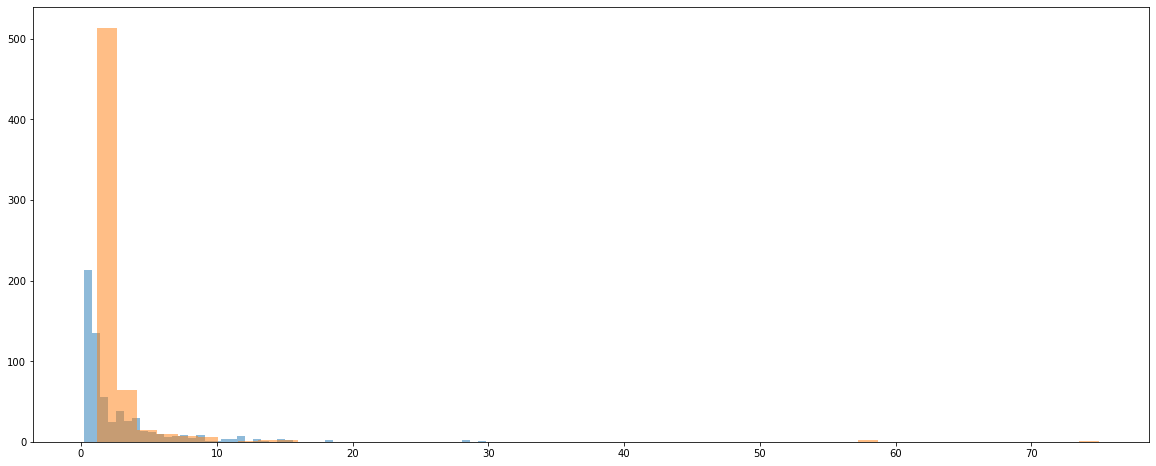

In [36]:
fig, ax = plt.subplots(figsize=(20,8))
plt.hist(plot_df.Original, bins = 50, alpha = 0.5, label="Ground Truth" )
plt.hist(plot_df.Predicted, bins = 50, alpha = 0.5, label="Predicted" )

PFAS6 v. PFAS18 visual

In [37]:
x = source_names
y = means

In [38]:
y18 = [32.50922,
 13.893400000000002,
 2.71944,
 13.284240000000002,
 17.35868,
 20.234939999999998]

yerror18 = [2.679220000000001,
 1.0234000000000023,
 0.32943999999999996,
 0.914240000000003,
 3.7486800000000002,
 1.4149399999999979]

In [39]:

from matplotlib.transforms import Affine2D

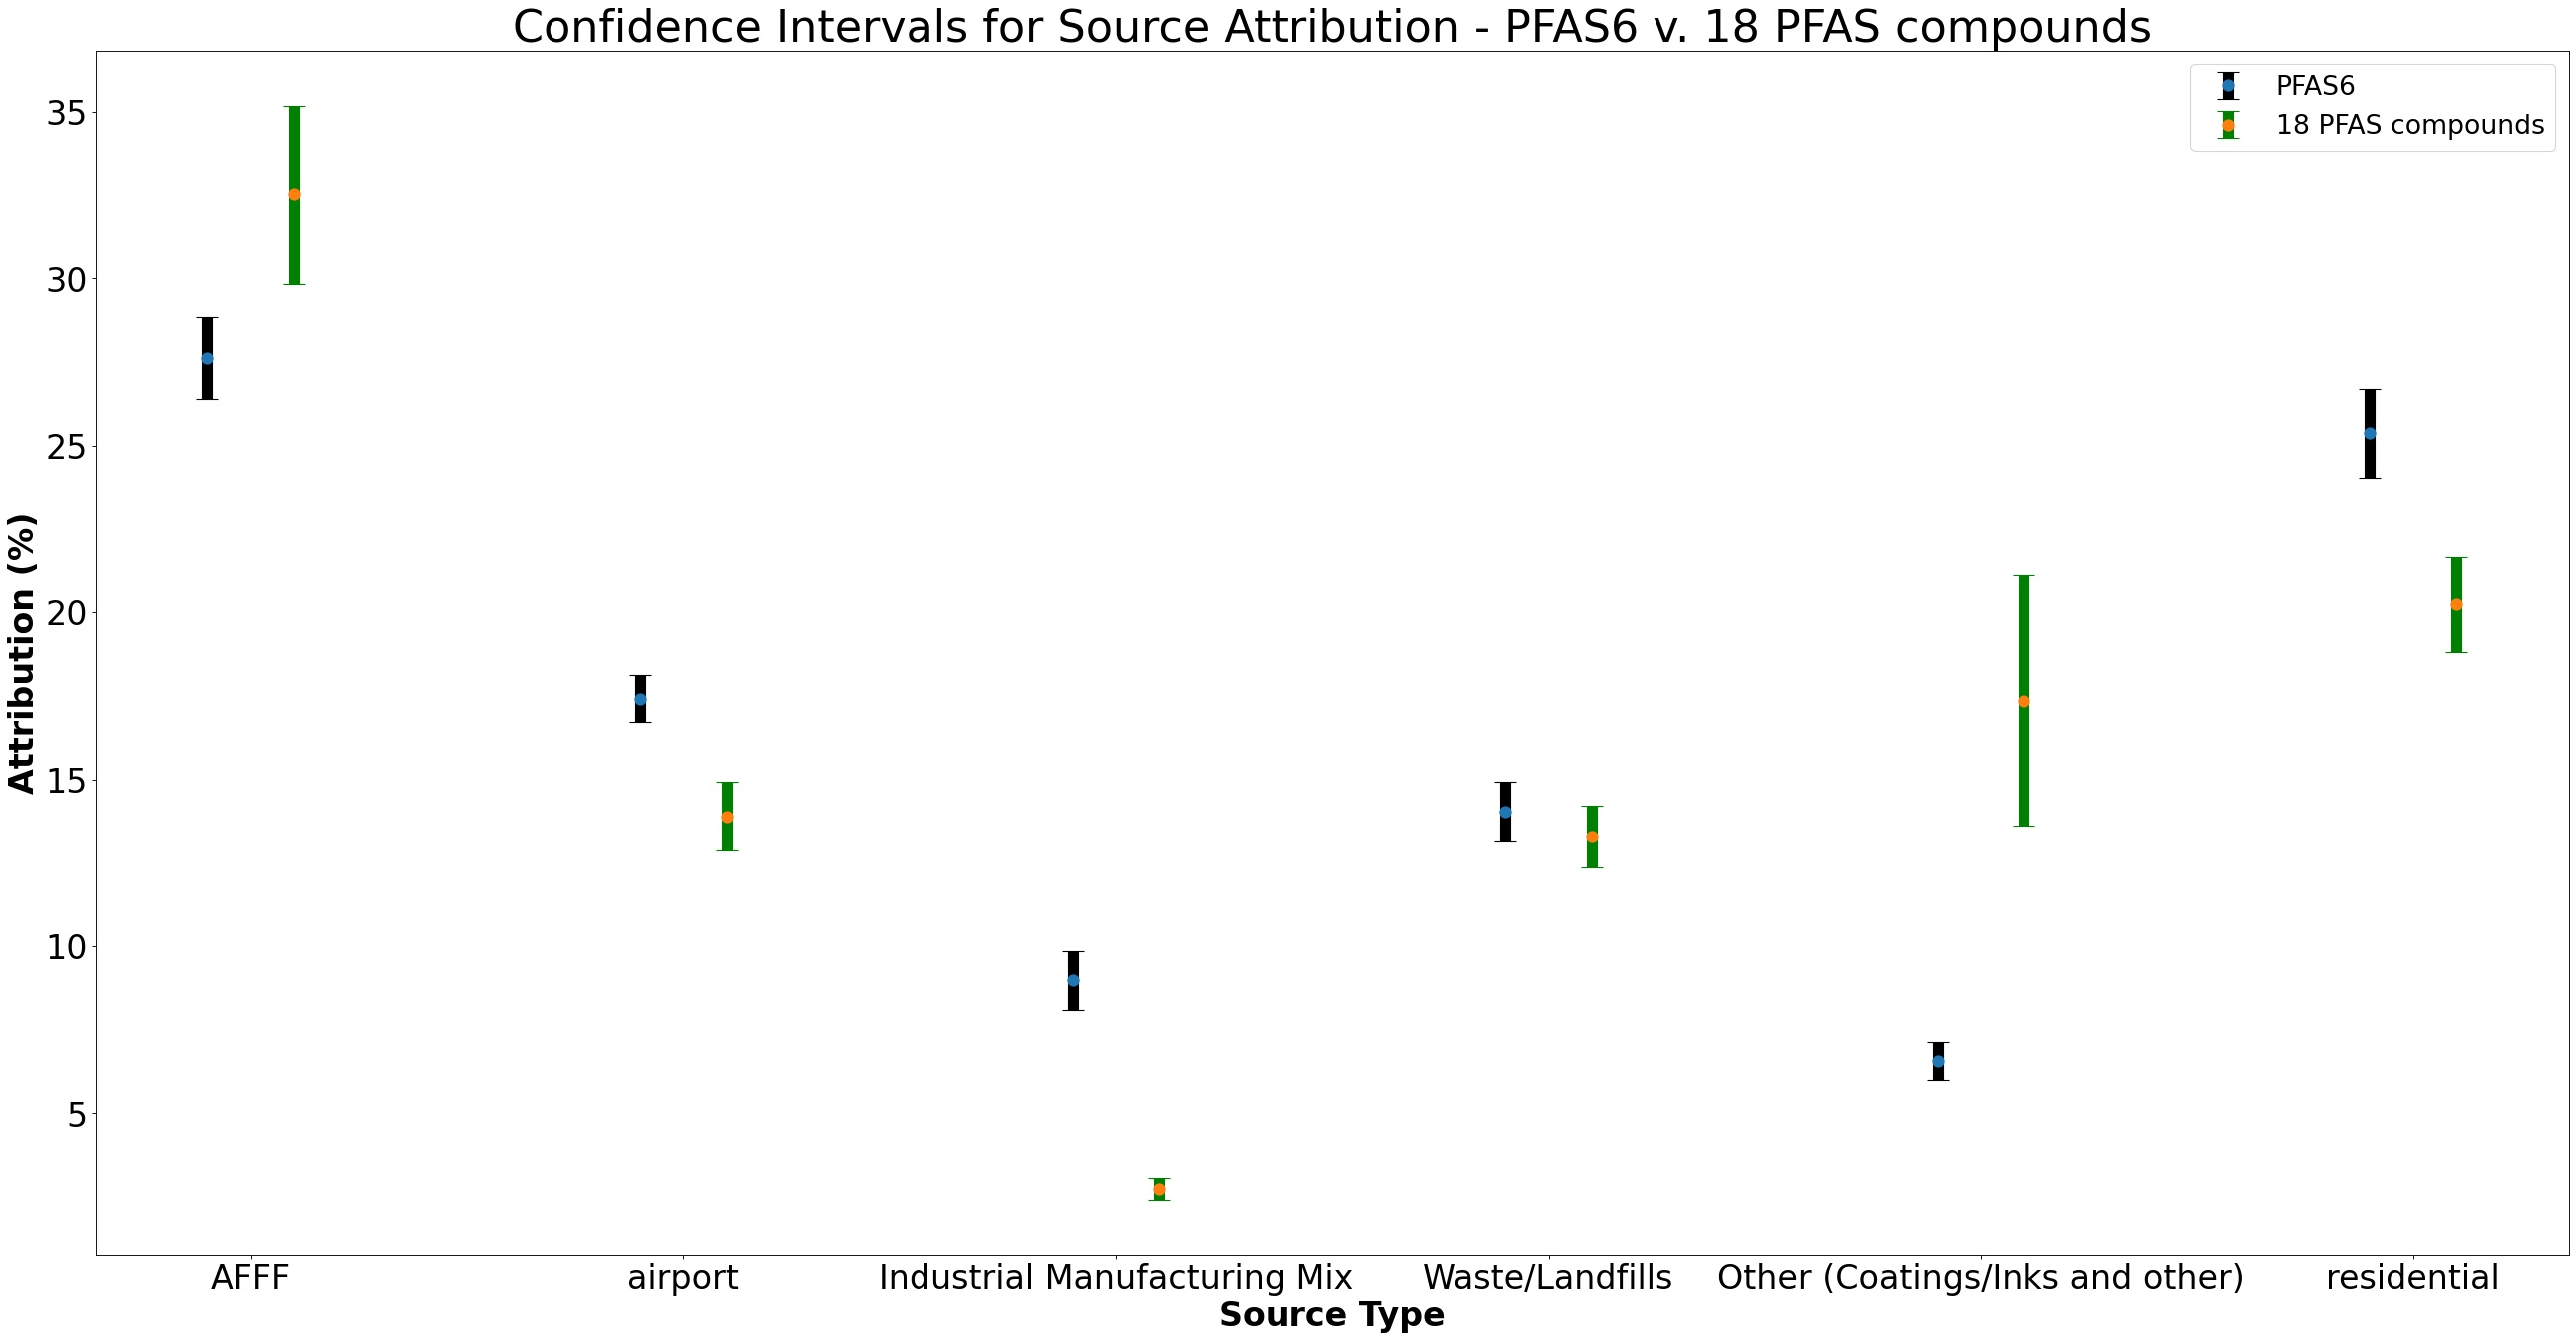

In [40]:
fig, ax = plt.subplots(figsize=(40, 20), dpi=80)

plt.title('Confidence Intervals for Source Attribution - PFAS6 v. 18 PFAS compounds', fontsize = 40)

plt.xlabel('Source Type', fontsize = 30, fontweight = 'bold')
plt.ylabel('Attribution (%)', fontsize = 30, fontweight = 'bold')

trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData

er1 = ax.errorbar(x, y, yerr = yerror, fmt = 'o', ecolor = 'black', capsize = 10, ms = 10, elinewidth = 10, transform = trans1, label = 'PFAS6')
er2 = ax.errorbar(x, y18, yerr = yerror18, fmt = 'o', ecolor = 'green', capsize = 10, ms = 10, elinewidth = 10, transform = trans2, label = '18 PFAS compounds')

# plt.xticks(rotation=30)

ax.tick_params(axis='both', which='major', labelsize=30)

ax.legend(fontsize = 24)

plt.show()

In [41]:
y_se = [9.357980000000001,
 28.483739999999997,
 7.737060000000001,
 22.178759999999997,
 5.798920000000001,
 26.44358]

yerror_se = [1.3179800000000021,
 0.5237399999999965,
 0.9270600000000018,
 0.7287599999999976,
 1.0089200000000007,
 1.5935799999999993]

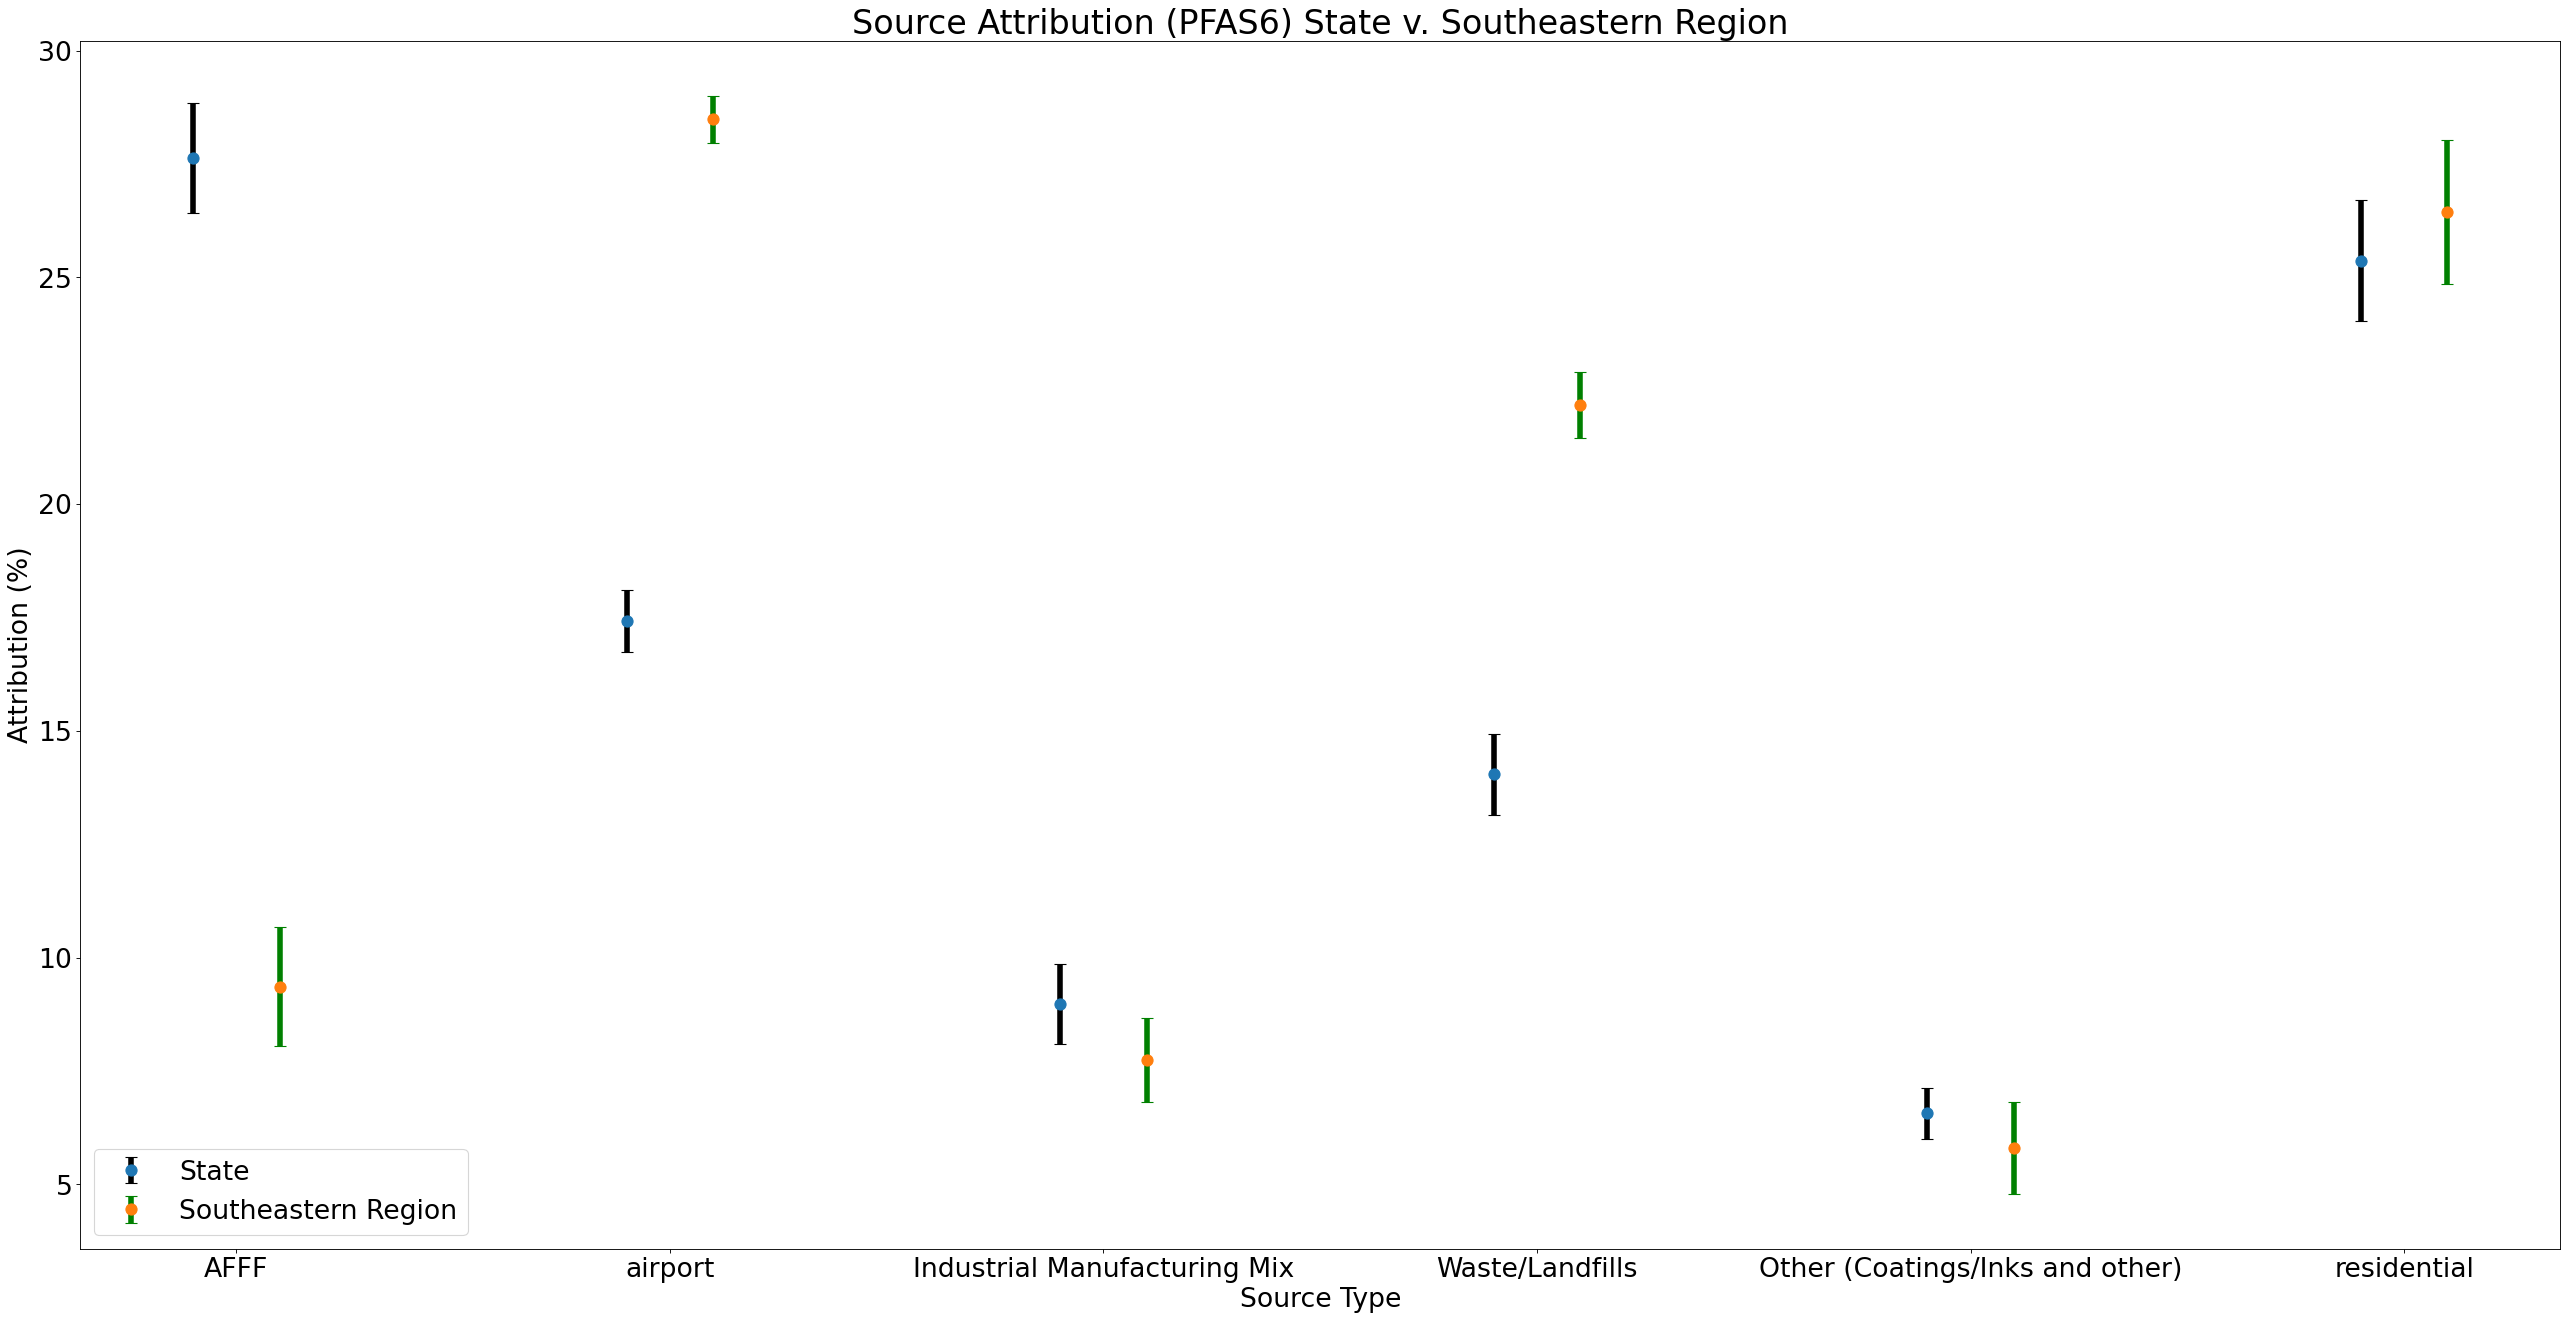

In [42]:
fig, ax = plt.subplots(figsize=(40, 20), dpi=80)

plt.title('Source Attribution (PFAS6) State v. Southeastern Region', fontsize = 30)

plt.xlabel('Source Type', fontsize = 24)
plt.ylabel('Attribution (%)', fontsize = 24)

trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData

er1 = ax.errorbar(x, y, yerr = yerror, fmt = 'o', ecolor = 'black', capsize = 5, ms = 10, elinewidth = 5, transform = trans1, label = 'State')
er2 = ax.errorbar(x, y_se, yerr = yerror_se, fmt = 'o', ecolor = 'green', capsize = 5, ms = 10, elinewidth = 5, transform = trans2, label = 'Southeastern Region')

# plt.xticks(rotation=30)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.legend(fontsize = 24)

plt.show()

In [45]:
y_ne = [14.40912, 13.35808, 8.60696, 9.61902, 8.55812, 45.4485]
yerror_ne = [2.269119999999999,
 1.82808,
 1.1069600000000008,
 1.819020000000001,
 1.168120000000001,
 2.4185000000000016]

y_west = [17.20928,
 21.81946,
 6.8441600000000005,
 14.84202,
 3.0530399999999998,
 36.232060000000004]
yerr_west = [1.7592800000000004,
 0.95946,
 1.3441600000000005,
 1.1420200000000005,
 0.5930399999999998,
 1.6020600000000016]

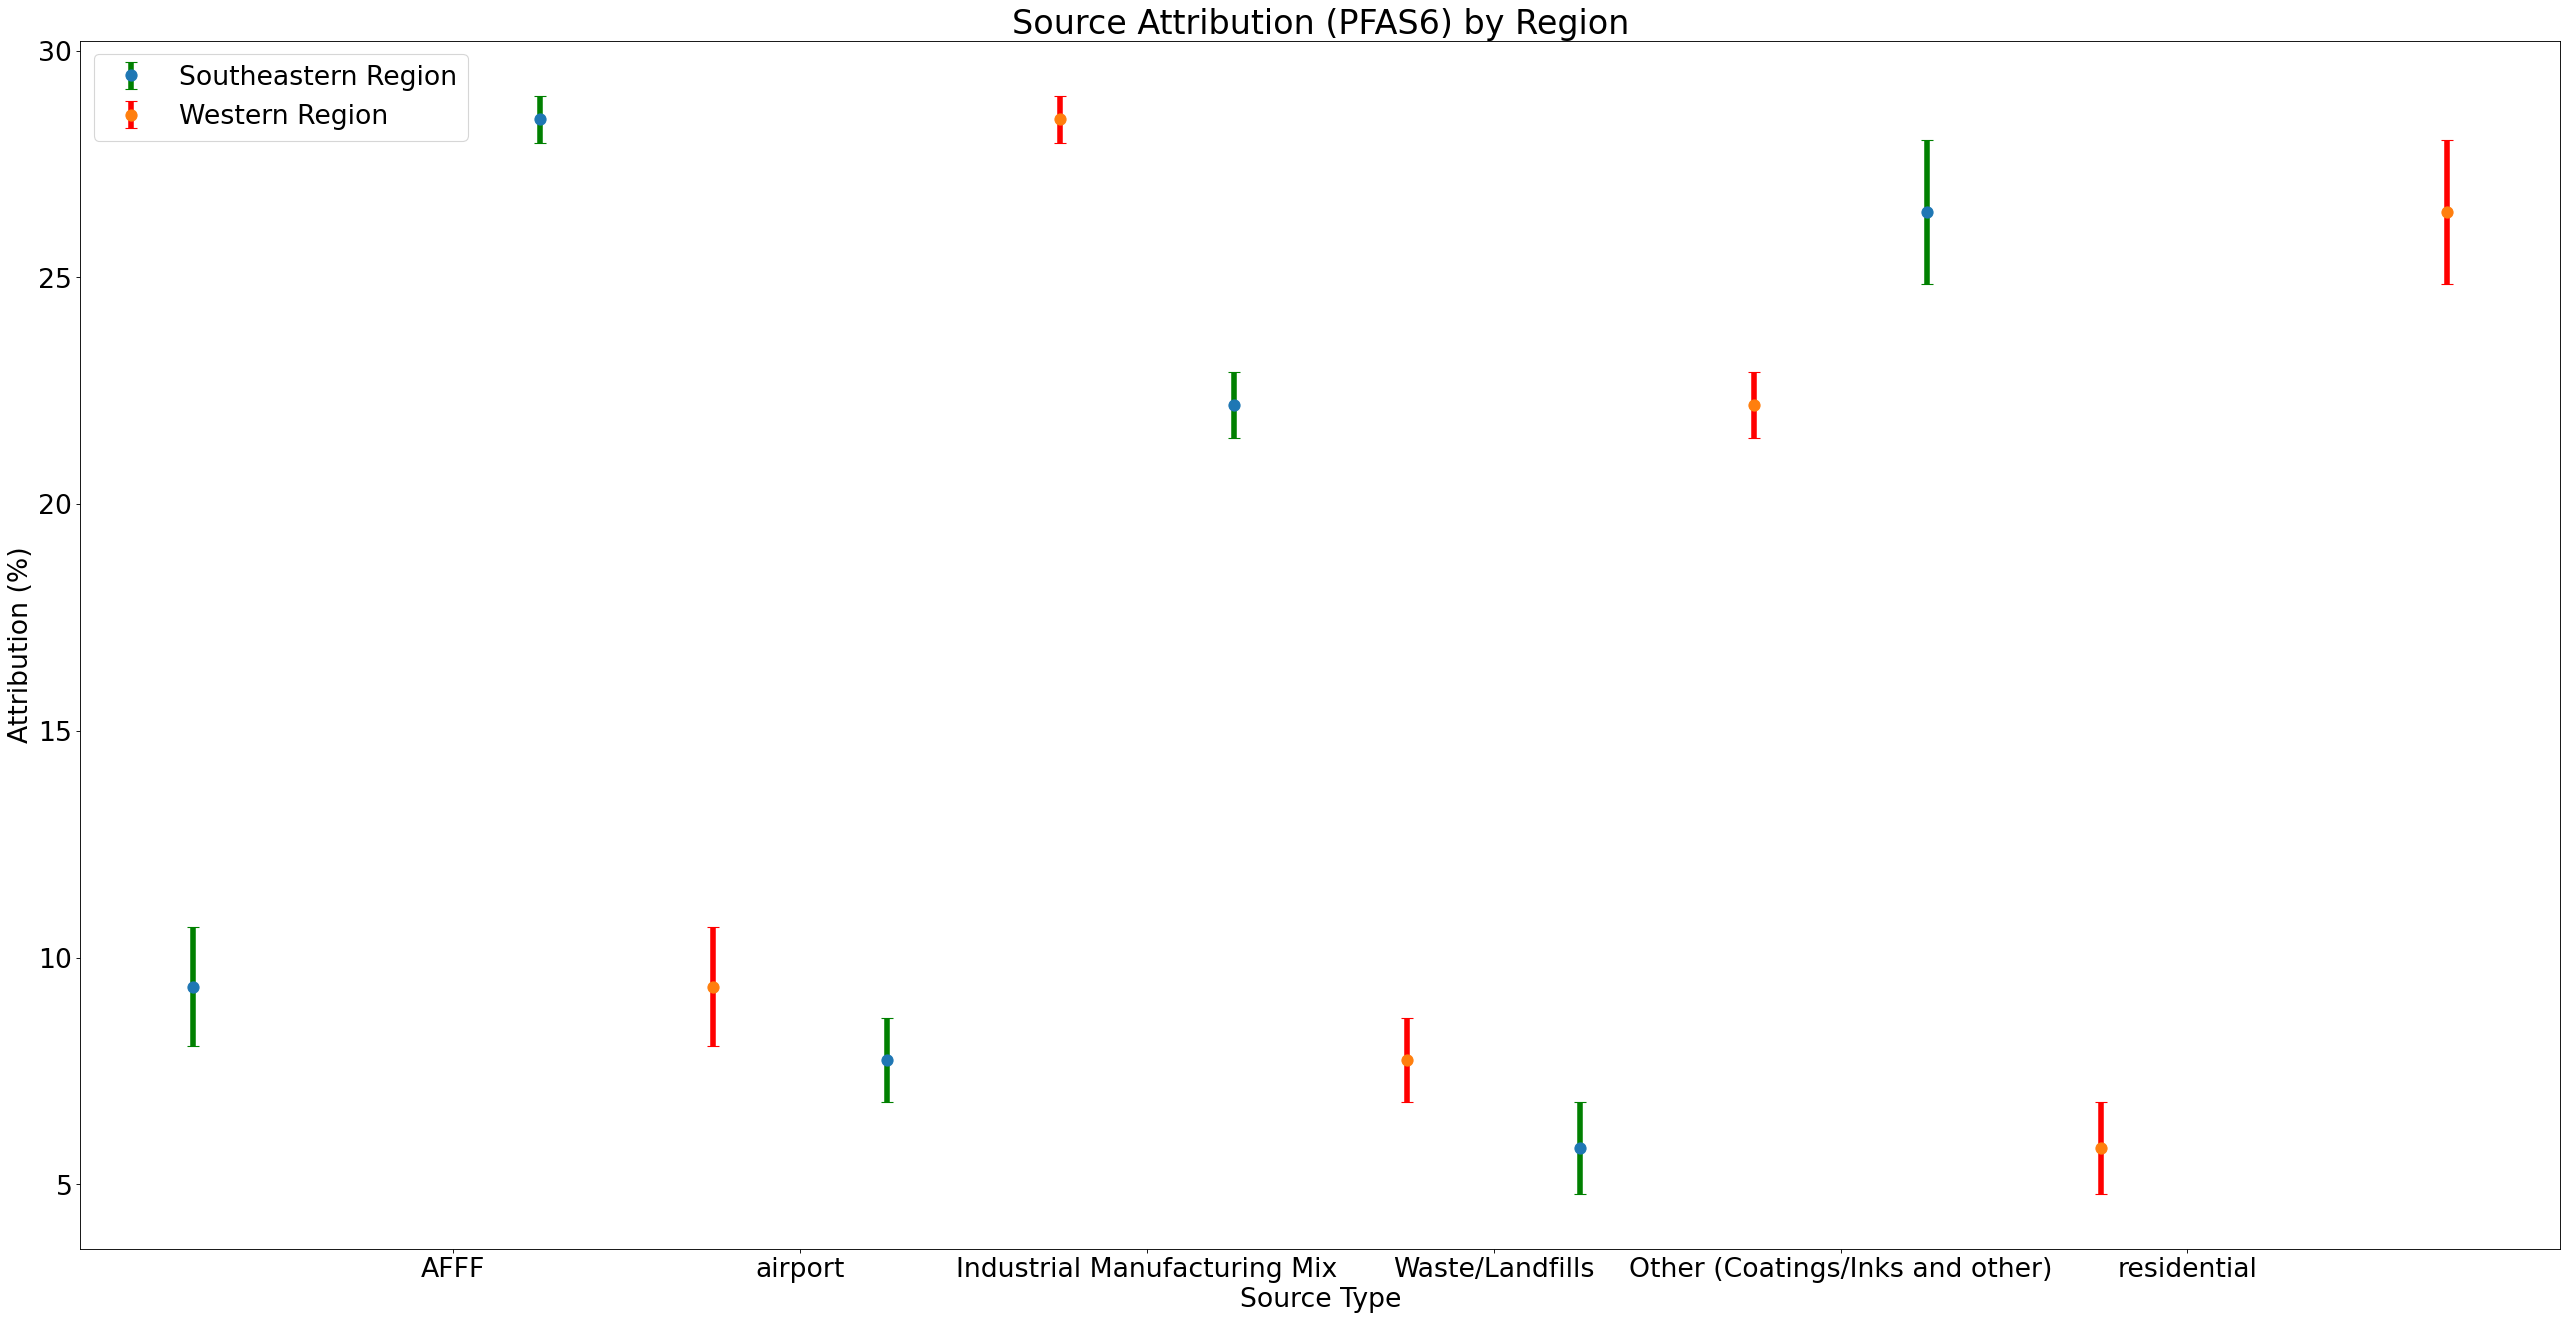

In [50]:
fig, ax = plt.subplots(figsize=(40, 20), dpi=80)

plt.title('Source Attribution (PFAS6) by Region', fontsize = 30)

plt.xlabel('Source Type', fontsize = 24)
plt.ylabel('Attribution (%)', fontsize = 24)

trans1 = Affine2D().translate(-0.75, 0.0) + ax.transData
# trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
trans3 = Affine2D().translate(+0.75, 0.0) + ax.transData

er2 = ax.errorbar(x, y_se, yerr = yerror_se, fmt = 'o', ecolor = 'green', capsize = 5, ms = 10, elinewidth = 5, transform = trans1, label = 'Southeastern Region')
# er2 = ax.errorbar(x, y_se, yerr = yerror_se, fmt = 'o', ecolor = 'blue', capsize = 5, ms = 10, elinewidth = 5, transform = trans2, label = 'Northeastern Region')
er2 = ax.errorbar(x, y_se, yerr = yerror_se, fmt = 'o', ecolor = 'red', capsize = 5, ms = 10, elinewidth = 5, transform = trans3, label = 'Western Region')

# plt.xticks(rotation=30)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.legend(fontsize = 24)

plt.show()